# Building Multimodal Model

In [1]:
cd ..

/notebooks/MultimodalTweetsClassification


In [2]:
#ensuring that any edits to libraries you make are reloaded here automatically
#to ensuere charts or images displayed are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

In [3]:
#importing required modules
from exp.Required_Modules_And_Packages import *
from exp.Data_Reading_And_Preprocessing import *
from exp.Required_Integration_Functionalities_For_Transformer_To_Fastai import *
from exp.Required_Functionalities_To_Handal_Multimodal_Dataset import *
from exp.Multimodal_Model_With_Intermediate_Or_EmbraceNet_Fusion import *

In [4]:
path = Path('/notebooks/MultimodalTweetsClassification')
# path.ls()

In [5]:
path_img = path/'data_image'

In [6]:
# Uncomment the code if dataset and labels are in .tar.gz and .zip format respectively

# data = "CrisisMMD_v2.tar.gz"
# agreed_label = "crisismmd_datasplit_agreed_label.zip"
# untar_data_and_unzip_label(data,agreed_label)

In [7]:
#reading csv files and doing initial necessary processing
data_human_text_image,test_data_human_text_image = get_dataframe(*get_tsv_data_files('humanitarian_task_tsv_files'),path)

reading data and preprocessing it.....
done!!


In [8]:
print(f"shape of data: {data_human_text_image.shape}\n")
print(f"train set: {data_human_text_image['is_valid'].value_counts()[0]}")
print(f"valid set: {data_human_text_image['is_valid'].value_counts()[1]}")      
print("="*50)
print(f"shape of test data: {test_data_human_text_image.shape}\n")

shape of data: (7124, 10)

train set: 6126
valid set: 998
shape of test data: (955, 9)



In [9]:
#creating databunch object language model to get encoder
data_lm = get_text_data_for_language_model(data_human_text_image,path)

In [10]:
# importing pretrained AWD_LSTM model and making learner object consist of data,model for training
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [11]:
# preprocessing and creating text databunch object for data(train and dev split) and test data(test split)
data_clas = get_text_data(data_human_text_image,path,vocab=data_lm.vocab)
test_data_clas = get_test_text_data(test_data_human_text_image,path,vocab=data_lm.vocab)

In [12]:
# making single databunch object of data and test data
data_clas.add_test(test_data_clas.train_ds)
data_clas.test_ds.y = test_data_clas.train_ds.y

In [13]:
#importing pretrained AWD-LSTM model and making learner object consist of data,model,metrics and callbacks for training
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,metrics=[accuracy,
                                                    Precision(average='macro'),Precision(average='weighted'),
                                                    Recall(average='macro'),Recall(average='weighted'),
                                                    FBeta(average='macro',beta=1),FBeta(average='weighted',beta=1)])

In [14]:
# laoding encoder for classification
learn_clas.load_encoder('fine_tuned_enc_human')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (6126 items)
x: TextList
xxbos california wildfires destroy more than structures kakenews,xxbos california wildfires destroy more than structures kakenews,xxbos california wildfires destroy more than structures kakenews,xxbos photos of california destructive wildfires via,xxbos why california wildfires are worse in the fall
y: CategoryList
infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,other_relevant_information
Path: /notebooks/MultimodalTweetsClassification;

Valid: LabelList (998 items)
x: TextList
xxbos family xxunk finds dog they lost when escaping california wildfires,xxbos hurricane irma on twitter,xxbos feel xxunk by xxunk in so many levels how xxunk can picture xxunk me so bad on the floor while preparing for,xxbos postirma can xxunk so true,xxbos hurricane maria remains severe threat sept utc
y: CategoryList
not_humanitarian,other_relev

In [15]:
#creating image databunch object for data(train and dev split) and test data(test split)
data_img = get_image_data(data_human_text_image,path,224)
test_data_img = get_test_image_data(test_data_human_text_image,path,224)

In [16]:
# making single databunch object of data and test data
data_img.add_test(test_data_img.x)
data_img.test_ds.y = test_data_img.y

In [17]:
# creating a learner object with image model to use it for concatenation 
arch = models.resnet50
learn_img = cnn_learner(data_img, arch, metrics=[accuracy,Precision(average='macro'),Precision(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [18]:
# learn_img.model

In [19]:
learn_img.model[-1] = learn_img.model[-1][:-3]
# learn_img.model

In [20]:
# learn_clas.model

In [21]:
learn_clas.model[-1].layers = learn_clas.model[-1].layers[:-3]
# learn_clas.model

In [22]:
#creating dataset object for ConcatDataset Class
train_ds = ConcatDataset(data_img.train_ds, data_clas.train_ds.x, data_clas.train_ds.y)
valid_ds = ConcatDataset(data_img.valid_ds, data_clas.valid_ds.x, data_clas.valid_ds.y)
test_ds = ConcatDataset(data_img.test_ds, data_clas.test_ds.x,data_clas.test_ds.y)

In [23]:
# creating data sampler object
bs = 16
train_sampler = SortishSampler(data_clas.train_ds.x, key=lambda t: len(data_clas.train_ds[t][0].data), bs=bs//2)
valid_sampler = SortSampler(data_clas.valid_ds.x, key=lambda t: len(data_clas.valid_ds[t][0].data))
test_sampler = SortSampler(data_clas.test_ds.x, key=lambda t: len(data_clas.test_ds[t][0].data))

In [24]:
# creating dataloader object for databuch
train_dl = DataLoader(train_ds, bs, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
test_dl = DataLoader(test_ds, bs, sampler=test_sampler)

In [25]:
#creating combined image+text databuch object to use it in learner for training 
data = DataBunch(train_dl=train_dl,valid_dl=valid_dl,test_dl=test_dl, device=defaults.device, 
                 collate_fn=my_collate, path=path)

In [26]:
(x1,x2),y = next(iter(data.valid_dl))
print(f'Shape image batch : {(x1.shape)}')
print(f'Shape text batch: {x2.shape}')
print(f'Shape dependent var: {y.shape}')

Shape image batch : torch.Size([16, 3, 224, 224])
Shape text batch: torch.Size([16, 24])
Shape dependent var: torch.Size([16])


In [27]:
lin_layers = [512+50, 5]
ps = 0.5
model = IntermediateConcatModel(learn_img.model, learn_clas.model, lin_layers, ps)

In [28]:
#making layer groupes and creating learner object for training
loss_func = nn.CrossEntropyLoss()
layer_groups = [nn.Sequential(*(flatten_model(learn_clas.layer_groups[0])+
                                flatten_model(learn_clas.layer_groups[1])+
                                flatten_model(learn_img.layer_groups[0]))),
                
                nn.Sequential(*(flatten_model(learn_clas.layer_groups[2])+
                                flatten_model(learn_clas.layer_groups[3])+
                                flatten_model(learn_img.layer_groups[1]))),
                
                nn.Sequential(*(flatten_model(learn_clas.layer_groups[4]) + 
                                flatten_model(learn_img.layer_groups[2]))),
               nn.Sequential(*flatten_model(model.layers))]
# layer_groups=layer_groups


# model.eval()
learn = Learner(data, model, loss_func=loss_func, metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)],
            callback_fns=[ShowGraph,partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3),
               partial(ReduceLROnPlateauCallback,monitor='valid_loss', mode='auto', patience=0,
                       factor=0.2, min_delta=0, min_lr=0.000001)],layer_groups=layer_groups)

In [29]:
# training model using discriminative fine-tunnig and gradual unfreezing
learn.freeze()

In [30]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


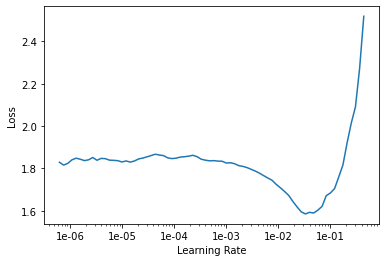

In [43]:
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,1.076867,0.812934,0.716433,0.529035,0.729597,0.563843,0.716433,0.537896,0.718823,00:43
1,0.732755,0.649667,0.759519,0.575338,0.752649,0.565435,0.759519,0.569422,0.754843,00:41
2,0.580876,0.643605,0.759519,0.571445,0.756433,0.568214,0.759519,0.568125,0.755904,00:41


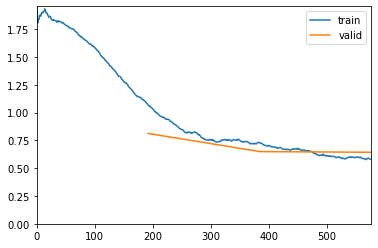

In [44]:
# training the model's top layer's keeping keep other layer's in freezing mode, all the metrics shown here, have been
# evaluted on validation set
learn.fit_one_cycle(3,1e-3, moms=(0.8, 0.7),wd=1e-1)

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.665223,0.637418,0.781563,0.635374,0.781766,0.623248,0.781563,0.627926,0.781001,00:41
1,0.441336,0.513980,0.829659,0.643248,0.824400,0.635452,0.829659,0.638545,0.826437,00:41


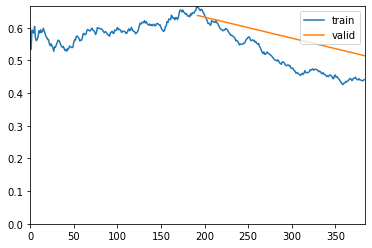

In [45]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.497852,0.645557,0.806613,0.613489,0.816005,0.649106,0.806613,0.626223,0.806621,00:50
1,0.402369,0.504130,0.812625,0.674112,0.810983,0.645651,0.812625,0.656450,0.809849,00:50
2,0.151539,0.523652,0.835671,0.663899,0.829139,0.637846,0.835671,0.649312,0.830550,00:50


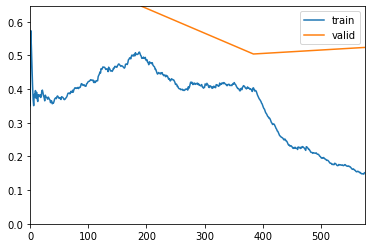

Better model found at epoch 0 with accuracy value: 0.8066132068634033.
Better model found at epoch 1 with accuracy value: 0.8126252293586731.
Better model found at epoch 2 with accuracy value: 0.8356713652610779.


In [46]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(2e-3/(2.6**4), 2e-3), moms=(0.8, 0.7), wd=1e-1,
                    callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

In [47]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.098911,0.624304,0.817635,0.646553,0.812681,0.622080,0.817635,0.632477,0.812658,00:59
1,0.063588,0.670207,0.824649,0.660639,0.820813,0.625977,0.824649,0.640801,0.819426,00:59


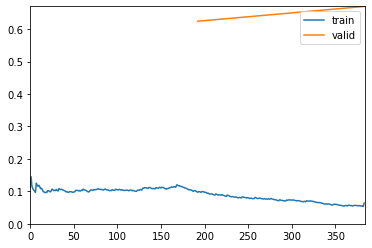

In [48]:
learn.fit_one_cycle(2, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.039444,0.740767,0.818637,0.655554,0.814916,0.616458,0.818637,0.632418,0.811844,00:59
1,0.047718,0.764802,0.828657,0.643405,0.822662,0.651701,0.828657,0.646887,0.825023,00:59
2,0.039459,0.744472,0.814629,0.638915,0.810860,0.630853,0.814629,0.631969,0.809542,00:59
3,0.019907,0.747701,0.820641,0.641430,0.815099,0.636528,0.820641,0.637425,0.816021,00:59


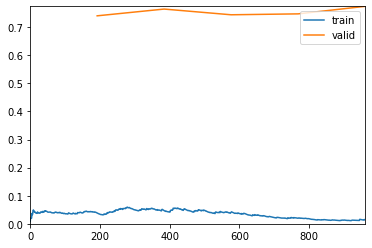

Better model found at epoch 0 with accuracy value: 0.8186372518539429.
Epoch 1: reducing lr to 9.504846320134734e-05
Better model found at epoch 1 with accuracy value: 0.828657329082489.
Epoch 2: reducing lr to 6.11262021936289e-05
Epoch 3: reducing lr to 1.8825834605023693e-05
Epoch 4: early stopping


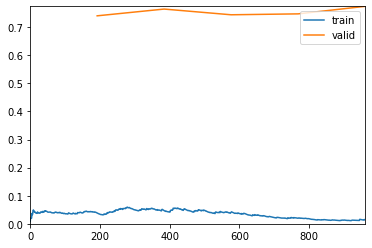

In [49]:
#training all layer's of the model and saving the best one 
learn.fit_one_cycle(5, slice(5e-4/(2.6**4), 5e-4), moms=(0.8, 0.7), wd=1e-1,
                    callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

In [50]:
# making interpretation on dev split
interp = ClassificationInterpretation.from_learner(learn,ds_type=DatasetType.Valid)

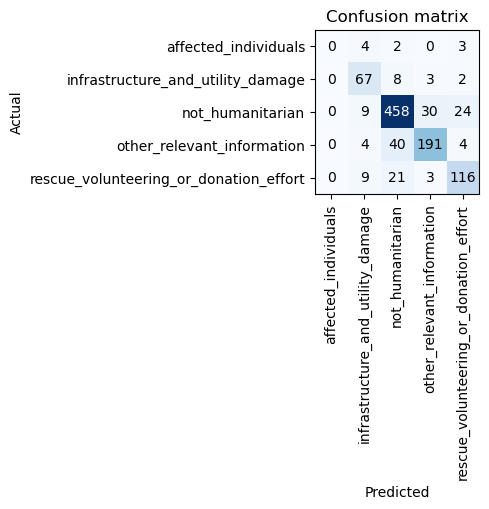

In [51]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

In [52]:
learn.validate(data.valid_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.80162054,
 tensor(0.8337),
 tensor(0.6412),
 tensor(0.8275),
 tensor(0.6589),
 tensor(0.8337),
 tensor(0.6490),
 tensor(0.8301)]

In [53]:
#making predictions on validation set to use it for classification report
valid_preds,valid_y,losses = learn.get_preds(ds_type=DatasetType.Valid,with_loss=True)
valid_y_preds = valid_preds.argmax(1)

target_names = ['affected_individuals',
 'infrastructure_and_utility_damage',
 'not_humanitarian',
 'other_relevant_information',
 'rescue_volunteering_or_donation_effort']

print(classification_report(valid_y, valid_y_preds, target_names=target_names))

                                        precision    recall  f1-score   support

                  affected_individuals       0.00      0.00      0.00         9
     infrastructure_and_utility_damage       0.72      0.84      0.77        80
                      not_humanitarian       0.87      0.88      0.87       521
            other_relevant_information       0.84      0.80      0.82       239
rescue_volunteering_or_donation_effort       0.78      0.78      0.78       149

                              accuracy                           0.83       998
                             macro avg       0.64      0.66      0.65       998
                          weighted avg       0.83      0.83      0.83       998



/opt/conda/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
# making interpretation on test split
interp = ClassificationInterpretation.from_learner(learn,ds_type=DatasetType.Test)

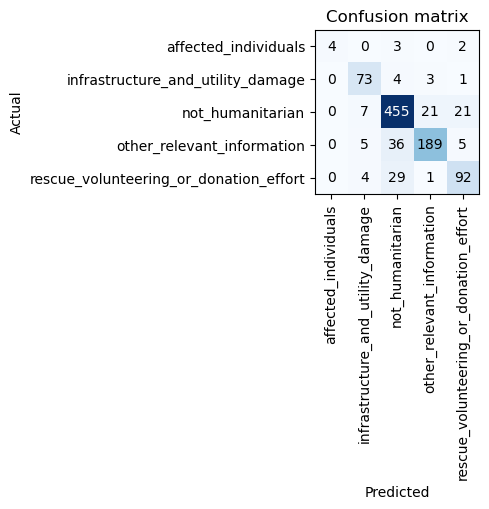

In [55]:
interp.plot_confusion_matrix(figsize=(5,5), dpi=100)

In [56]:
learn.validate(data.test_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.56692284,
 tensor(0.8513),
 tensor(0.8654),
 tensor(0.8523),
 tensor(0.7566),
 tensor(0.8513),
 tensor(0.7887),
 tensor(0.8499)]

In [57]:
#making predictions on test set to use it for classification report
test_preds,test_y,losses = learn.get_preds(ds_type=DatasetType.Test,with_loss=True)
test_y_preds = test_preds.argmax(1)

target_names = ['affected_individuals',
 'infrastructure_and_utility_damage',
 'not_humanitarian',
 'other_relevant_information',
 'rescue_volunteering_or_donation_effort']

print(classification_report(test_y, test_y_preds, target_names=target_names))

                                        precision    recall  f1-score   support

                  affected_individuals       1.00      0.44      0.62         9
     infrastructure_and_utility_damage       0.82      0.90      0.86        81
                      not_humanitarian       0.86      0.90      0.88       504
            other_relevant_information       0.88      0.80      0.84       235
rescue_volunteering_or_donation_effort       0.76      0.73      0.74       126

                              accuracy                           0.85       955
                             macro avg       0.87      0.76      0.79       955
                          weighted avg       0.85      0.85      0.85       955



In [58]:
learn.save("BEST_HUMANITARIAN_MODEL_INTERMEDIATE")